In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
path = r"Proposal/Figures/"
table_path = r"Proposal/Tables/"

$$ z_k = \frac{G}{B} = \left(\frac{\alpha}{1-\alpha}\frac{r^B}{r^G}\right)^{\gamma_s}$$
$$ z_l = \frac{L}{K} =  \frac{1-\beta}{\beta} \frac{1}{\alpha}(\alpha_s + (1-\alpha_s) z_k^{-\frac{\gamma_s-1}{\gamma_s}})^{\frac{1}{\gamma_s-1}} \frac{r^G}{W} $$


In [2]:
def function_z_k(α,γ,r_b, green_premium,τ_E,A_tilde):
    r_g = (1-green_premium) * r_b
    return (α/(1-α) * (r_b +τ_E/1000*A_tilde )/r_g) ** (γ)
def function_z_l(z_k,β,α,γ,w,green_premium,r_b):
    r_g = (1-green_premium) * r_b
    return ((1-β)/β/α)* ((α + (1-α)*(z_k** (-(γ-1)/γ)) ) ** (1/(γ-1))) * (r_g/w)

def function_intensity(A_tilde,A_hat,α,γ,z_l,z_k,β):
    return (A_tilde/A_hat) * (α * (z_k ** ((γ-1)/γ)) + (1 - α)) ** (γ / (1-γ)) * (z_l ** (β-1))

def function_price_detail(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E):
    r_g = (1-green_premium) * r_b
    C_G = r_g * (((α + (1-α)*(z_k** (-(γ-1)/γ)) ) ** (γ / (1-γ))) * (z_l ** (β-1)))
    C_B = r_b * ((α * (z_k ** ((γ-1)/γ)) + (1 - α)) ** (γ / (1-γ))) * (z_l ** (β-1))
    c_L = w * z_l ** (β)
    C_E = τ_E/1000 * A_tilde * C_B/r_b
    return C_G,C_B,c_L,C_E
    
def function_price(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E,detail=False):
    C_G,C_B,c_L,C_E = function_price_detail(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E)
    if detail:
        return C_G,C_B,c_L,C_E, σ/(σ-1) * (C_G + C_B + c_L + C_E) / A_hat
    else:
        return σ/(σ-1) * (C_G + C_B + c_L + C_E) / A_hat
    
    
def optimal_labor(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E,κ=1e3):
    p = function_price(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E)
    return κ * z_l ** (β) * (p ** (-σ))/A_hat

def production_function(A_hat,β,z_l,L):
    return A_hat * (z_l ** (β)) * L

def brown_capital(A_hat,α,z_k,z_l,γ,β,Y):
    return (Y/A_hat) * ((α * (z_k ** ((γ-1)/γ)) + (1 - α)) ** (γ / (1-γ))) * (z_l ** (β-1))

def green_capital(A_hat,α,z_k,z_l,γ,β,Y):
    return (Y/A_hat) * ((α + (1-α)*(z_k** (-(γ-1)/γ)) ) ** (γ / (1-γ))) * (z_l ** (β-1))


def optimal_ratios(input_0,τ_E):
    z_k = function_z_k(input_0['α'],input_0['γ'],input_0['r_b'], input_0['green_premium'],τ_E,input_0['A_tilde'])
    z_l = function_z_l(z_k,input_0['β'],input_0['α'],input_0['γ'],input_0['w'],input_0['green_premium'],input_0['r_b'])
    return z_k,z_l

def ratios_gen(input_0):
    z_k,z_l = optimal_ratios(input_0,input_0['τ_E'])
    l = optimal_labor(input_0['A_tilde'],input_0['A_hat'],input_0['α'],input_0['γ'],z_l,z_k,input_0['β'],input_0['w'],input_0['green_premium'],input_0['r_b'],input_0['σ'],input_0['τ_E'])
    y = production_function(input_0['A_hat'],input_0['β'],z_l,l)
    p = function_price(input_0['A_tilde'],input_0['A_hat'],input_0['α'],input_0['γ'],z_l,z_k,input_0['β'],input_0['w'],input_0['green_premium'],input_0['r_b'],input_0['σ'],input_0['τ_E'])
    b = brown_capital(input_0['A_hat'],input_0['α'],z_k,z_l,input_0['γ'],input_0['β'],y)
    g = green_capital(input_0['A_hat'],input_0['α'],z_k,z_l,input_0['γ'],input_0['β'],y)
    return z_k,z_l,l,y*1e3,p, g, b




def simulate_firms(n,A_tilde,A_hat,α,γ,r_b, green_premium,τ_E,β,w,σ):
    # simulate over multiple firms
    r_g = (1-green_premium) * r_b
    np.random.seed(0)
    A_tilde_vector = (1 + np.random.lognormal(mean=0,sigma=1,size=n)) * A_tilde
    A_hat_vector = (1 + np.random.lognormal(mean=0,sigma=1,size=n)) * A_hat
    intensity = []
    production = []
    emissions = []
    emission_cost = []
    G_c = []
    B_c = []
    labor = []
    for i in zip(A_tilde_vector,A_hat_vector):
        z_k = function_z_k(α,γ,r_b, green_premium,τ_E,i[0])
        z_l = function_z_l(z_k,β,α,γ,w,green_premium,r_b)
        p = function_price(i[0],i[1],α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E)
        l = optimal_labor(i[0],i[1],α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E)
        IN = function_intensity(i[0],i[1],α,γ,z_l,z_k,β)
        Y = production_function(i[1],β,z_l,l)
        intensity.append(IN)
        production.append(Y)
        emissions.append(IN * Y)
        emission_cost.append(τ_E/1000 * IN * Y)
        G_c.append(green_capital(i[1],α,z_k,z_l,γ,β,Y))
        B_c.append(brown_capital(A_hat,α,z_k,z_l,γ,β,Y))
        labor.append(l)
    return CES_aggregator(emissions,np.inf),CES_aggregator(production,σ),sum(intensity)/n,production,emission_cost,G_c,B_c,labor
def CES_aggregator(array,σ):
    if σ != np.inf:
        return sum([i ** ((σ-1)/σ) for i in array]) ** (σ/(σ-1))
    else:
        return sum(array)


In [3]:

def gen_df(params,τ_E):
    params_0 = params.copy()
    params_0['τ_E'] = τ_E 
    params_1 = params_0.copy()
    res_1 = ratios_gen(params_1)
    params_2 = params_0.copy()
    params_2['A_hat'] = params_2['A_hat'] * 0.8
    params_2['A_tilde'] = params_2['A_tilde'] * 1.2
    res_2 = ratios_gen(params_2)
    # put the results into a dataframe
    df = pd.DataFrame([res_1,res_2],columns=['z_k','z_l','l','y','p','g','b'])
    # df['income'] = (df.y * df.p).round(2)
    # # df['emission'] = df.emission.round(2)
    # # add sum row
    # df.loc['sum'] = np.nan
    # df.loc['sum','l']= df.l.sum()
    # df.loc['sum','g']= df.g.sum()
    # df.loc['sum','b']= df.b.sum()
    # df.loc['sum','income']= df.income.sum()
    # p_s = 0
    # y_s = 0
    # for i in [res_1,res_2]:
    #     p_s += i[4] ** (1-params_0['σ'])
    #     y_s += i[3] ** ((params_0['σ']-1)/(params_0['σ']))
    # p_s = p_s ** (1/(1-params_0['σ']))
    # y_s = y_s ** (params_0['σ']/(params_0['σ']-1))
    # df.loc['sum','p'] = p_s
    # # df.p = df.p/p_s
    # df.loc['sum','y'] = y_s
    return df
parameters = {
    'β': 0.6,
    'γ':5,
    'α': 0.25,
    'A_hat': 0.1,
    'A_tilde': 0.018,
    'μ': 0,
    'θ': 1,
    'η': np.inf,
    'σ': 5,
    'r_b': 0.05,
    'green_premium': 0,
    'w': .500, # MSEK
    'τ_E': 0,# per ton
    'n': int(1e3)}

# CO2 Emission is 13800 Kton
# Labor 500 TSEK

tax = 20
tax_2 = -20
df = pd.concat([gen_df(parameters,tax_2),gen_df(parameters,0),gen_df(parameters,tax)],keys=['τ_E = {}'.format(tax_2),'τ_E = 0','τ_E = {}'.format(tax)],axis=0)
df

z_k       z_l         l          y         p         g  \
τ_E = -20 0  0.003969  0.750631  0.877201  73.850780  6.257940  0.004687   
          1  0.003940  0.751717  0.358881  24.192072  7.825615  0.001904   
τ_E = 0   0  0.004115  0.745249  0.882257  73.956392  6.245355  0.004880   
          1  0.004115  0.745249  0.361372  24.234031  7.806694  0.001999   
τ_E = 20  0  0.004266  0.739943  0.887182  74.051130  6.233060  0.005078   
          1  0.004296  0.738891  0.363787  24.270858  7.788294  0.002097   

                    b  
τ_E = -20 0  1.180842  
          1  0.483260  
τ_E = 0   0  1.185767  
          1  0.485690  
τ_E = 20  0  1.190506  
          1  0.488010

In [6]:
τ_E = 20
z_k,z_l = optimal_ratios(parameters,τ_E)
res1 = function_price(parameters['A_tilde'],parameters['A_hat'],parameters['α'],parameters['γ'],z_l,z_k,parameters['β'],parameters['w'],parameters['green_premium'],parameters['r_b'],parameters['σ'],τ_E,detail=True)
res1 = res1 + (z_k,z_l)
z_k,z_l = optimal_ratios(parameters,0)
res2 = function_price(parameters['A_tilde'],parameters['A_hat'],parameters['α'],parameters['γ'],z_l,z_k,parameters['β'],parameters['w'],parameters['green_premium'],parameters['r_b'],parameters['σ'],0,detail=True)
res2 = res2 + (z_k,z_l)
df = pd.DataFrame([res2,res1],columns=['C_G','C_B','c_L','C_E','P','z_k','z_l'],index=['τ_E = 0','τ_E = {}'.format(τ_E)])

df


,C_G,C_B,c_L,C_E,P,z_k,z_l
τ_E = 0,0.000330,0.080167,0.419132,0.000000,6.245355,0.004115,0.745249
τ_E = 20,0.000343,0.080384,0.417339,0.000579,6.233060,0.004266,0.739943


In [84]:

z_k,z_l,l,Y,p, intensity, emission = ratios_gen(parameters)
print("z_k: ",z_k,"\nz_l: ",z_l,"\nprice: ",p,"\nlabor: ",l)
print("intensity: (KG/SEK) ",function_intensity(params['A_tilde'],params['A_hat'],params['α'],params['γ'],z_l,z_k,params['β']))
print("production: (MSEK)",production_function(params['A_hat'],params['β'],z_l,l))
print("emission: (ton)",function_intensity(params['A_tilde'],params['A_hat'],params['α'],params['γ'],z_l,z_k,params['β']) * production_function(params['A_hat'],params['β'],z_l,l))

##
print("-"*50)
##

emission, production, intensity, _, emission_cost, G_c, B_c,labor = simulate_firms(params['n'],params['A_tilde'],params['A_hat'],params['α'],params['γ'],params['r_b'], params['green_premium'],params['τ_E'],params['β'],params['w'],params['σ'])
print("Intensity: (KG/SEK)",intensity)
print("Emission: (MTon) ",emission/1e6)
print("Production: (BSek) ",production/1e6)
print("Emission/Production: (KG/SEK) ",emission/production)
print("Emission cost: ",sum(emission_cost))
print("Green Capital: ",sum(G_c))
print("Brown Capital: ",sum(B_c))

z_k:  0.004115226337448558 
z_l:  0.7452486380456645 
price:  6.245355180018898 
labor:  0.8822567781109816
intensity: (KG/SEK)  0.2885997885284118
production: (MSEK) 0.0739563924230961
emission: (ton) 0.02134379921362977
--------------------------------------------------
Intensity: (KG/SEK) 0.36854190297352435
Emission: (MTon)  0.04200243076116298
Production: (BSek)  2.1701605444693874
Emission/Production: (KG/SEK)  0.019354526958019477
Emission cost:  0.0
Green Capital:  4596.2735082748295
Brown Capital:  18526585.919793084


In [77]:
params

{'β': 0.6,
 'γ': 5,
 'α': 0.25,
 'A_hat': 0.1,
 'A_tilde': 0.018,
 'μ': 0,
 'θ': 1,
 'η': inf,
 'σ': 5,
 'r_b': 0.05,
 'green_premium': 0,
 'w': 0.5,
 'τ_E': 0,
 'n': 1000}

C:\Users\SE.5203\AppData\Local\Temp\ipykernel_11464\3388865582.py:6: RuntimeWarning: invalid value encountered in scalar power
  return ((1-β)/β/α)* ((α + (1-α)*(z_k** (-(γ-1)/γ)) ) ** (1/(γ-1))) * (r_g/w)
C:\Users\SE.5203\AppData\Local\Temp\ipykernel_11464\3388865582.py:13: RuntimeWarning: invalid value encountered in scalar power
  C_G = r_g * (((α + (1-α)*(z_k** (-(γ-1)/γ)) ) ** (γ / (1-γ))) * (z_l ** (β-1)))
C:\Users\SE.5203\AppData\Local\Temp\ipykernel_11464\3388865582.py:14: RuntimeWarning: invalid value encountered in scalar power
  C_B = r_b * ((α * (z_k ** ((γ-1)/γ)) + (1 - α)) ** (γ / (1-γ))) * (z_l ** (β-1))


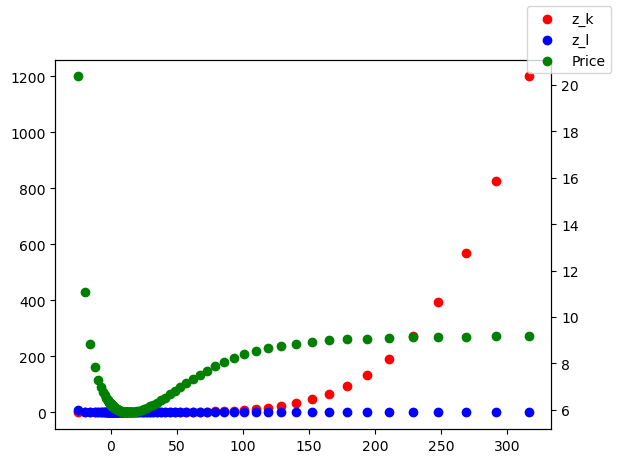

In [102]:
def price_test(input_0,τ_E):
    z_k = function_z_k(input_0['α'],input_0['γ'],input_0['r_b'], input_0['green_premium'],τ_E,input_0['A_tilde'])
    z_l = function_z_l(z_k,input_0['β'],input_0['α'],input_0['γ'],input_0['w'],input_0['green_premium'],input_0['r_b'])
    p = function_price(input_0['A_tilde'],input_0['A_hat'],input_0['α'],input_0['γ'],z_l,z_k,input_0['β'],input_0['w'],input_0['green_premium'],input_0['r_b'],input_0['σ'],τ_E)
    return p,z_k,z_l
# print()
params_0 = params.copy()
params_0['σ'] = 5
# params_0['γ'] = 1100
x_test = []
y_test = []
k_test = []
l_test = []
import matplotlib.pyplot as plt

for i in np.append(np.logspace(-1,2.5,100), -np.logspace(-1,1.5,25)):
    p,z_k,z_l = price_test(params_0,i*1e2)
    if ~np.isnan(p):
        x_test.append(i)
        y_test.append(p)
        k_test.append(z_k)
        l_test.append(z_l)
# 
fig, ax1 = plt.subplots()

ax1.scatter( x_test,k_test,color='r',label=False)
ax1.scatter( x_test,l_test,color='b',label=False)
ax2 = ax1.twinx()
ax2.scatter( x_test,y_test,color='g',label=False)
fig.legend(['z_k','z_l','Price'])
plt.show()


In [167]:
def test_func(params_0):
    z_k = function_z_k(params_0['α'],params_0['γ'],params_0['r_b'], params_0['green_premium'],params_0['τ_E'],params_0['A_tilde'])
    z_l = function_z_l(z_k,params_0['β'],params_0['α'],params_0['γ'],params_0['w'],params_0['green_premium'],params_0['r_b'])
    l = optimal_labor(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    y = production_function(params_0['A_hat'],params_0['β'],z_l,l)
    p = function_price(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    C_G,C_B,c_L,C_E = function_price_detail(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    return z_k,z_l,l,y*1e3,p,C_G,C_B,c_L,C_E

params_0 = params.copy()
params_0['σ'] = 5
params_0['w'] = params_0['w'] / 1e3
params_0['τ_E'] = 20 * 1e2
z_k,z_l,l,y,p,C_G,C_B,c_L,C_E = test_func(params_0)
print("C_G:", C_G)
print("C_B:", C_B)
print("c_L:", c_L)
print("C_E:", C_E)
print("P: ",params_0['σ']/(params_0['σ']-1) * (C_G + C_B + c_L + C_E) / params_0['A_hat'])





C_G: 0.03250359679419391
C_B: 0.01863539549533783
c_L: 1.1337234725274548
C_E: 0.013417484756643235
P:  14.978499369670372
